In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder

In [132]:
lst = pd.read_csv("listings.csv")
cal = pd.read_csv("calendar.csv")
rev = pd.read_csv("reviews.csv")

Need to write a function that will tell me basics about each file in terms of:
- display the head info for each dataframe
- number of rows and columns
- which features have only one value (these could be dropped)
- which features are categorical vs numeric
- basic statistics about the numeric features
- unique values of the categorical features
- info relating to the missing data including how many features have missing data, proportion of missing by feature

In [288]:
def describe_data(df, csv_name):
    dash = '-' * 70
    newline = '\n' * 3
    df_len = len(df)
    
    # head info
    print(f'{dash}Head Information for {csv_name}{dash}')
    display(df.head())
    
    # basic shape and stats
    print(newline)
    print(f'{dash}Basic Shape Information for {csv_name}{dash}')
    print(f'{csv_name} contains {df.shape[0]:,} rows and {df.shape[1]:,} columns.')
    
    # fid columns with just one value, these can be dropped
    drop_columns = []
    for col in df:
        if len(df[col].unique()) == 1:
            drop_columns.append(col)
    
    print(newline)
    print(f'The following columns only contain one value and can be dropped: {", ".join(drop_columns)}')
    
    # list the numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    print(newline)
    print(f'These columns are numeric: {", ".join(numeric_cols)}')
    
    # print descriptive statistics for dataframe
    print(newline)
    print(f'{dash}Basic statistics for {csv_name}{dash}')
    with pd.option_context('display.max_columns', None):
        display(df.describe())
        
    print(newline)
    print(f'{dash}Histograme of numeric features {csv_name}{dash}')
    df.hist(figsize=(20,10));
    plt.tight_layout()
    plt.show(plt.gcf())
    
    
    # print numeric info
    print(newline)
   # print(f'{dash}First 5 top values with counts for each non-numeric feature {csv_name}{dash}')
    for col in df[numeric_cols]:
        num_na = df[col].isna().sum()
        num_filled = df_len - num_na
        proportion_na = num_na / df_len        
        col_mean = df[col].mean()
        col_median = df[col].median()
        print(f'{df[col].name}|| mean: {col_mean:,.0f}   median: {col_median:,.0f}   Not_NA: {num_filled:,.0f}   NA: {num_na:,.0f} proportion_NA: {proportion_na:.1%}\n')
    
    
    
    # get general info on non-numeric features
    non_numeric_cols = df.select_dtypes(exclude='number').columns
    print(newline)
    print(f'These columns are non-numeric dtypes: {", ".join(non_numeric_cols)}')
    
    print(newline)
    print(f'{dash}First 5 top values with counts for each non-numeric feature {csv_name}{dash}')
    for col in df[non_numeric_cols]:
        # get count info about column
        num_unique = len(df[col].unique())
        num_na = df[col].isna().sum()
        num_filled = df_len - num_na
        proportion_na = num_na / df_len        
        
        # get info about top values
        names = list(df[col].value_counts()[0:5].index)
        sliced_names = [name[:25] for name in names]
        values = list(df[col].value_counts()[0:5])
        print(f'{df[col].name}: {list(zip(sliced_names,values))}')
        print(f'num_unique: {num_unique:,.0f}   not_NA: {num_filled:,.0f}   NA: {num_na:,.0f}   proportion_NA: {proportion_na:.1%}\n')
        
        
    # More information about missing data
    print(newline)
    print(f'{dash}More information about missing data for {csv_name}{dash}')
    
    # visualize how many rows per column have null values.
    missing_data = df.isna().sum(axis=0)

    plt.figure(figsize=(7,20))
    sns.barplot(y=missing_data.index,
                x=missing_data.values,
                color='blue'
               );
    plt.xticks(rotation=45);
    plt.title('Count of Missing Values in Dataframe by column');
    plt.show(plt.gcf())
    
    #show column missing data as a histogram
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sns.ecdfplot(missing_data, ax=axs[1]);
    sns.histplot(x=missing_data, ax=axs[0], stat='probability');
    axs[0].set_xlabel('Number of missing values per column')
    axs[0].set_ylabel('Proportion of column')
    axs[1].set_xlabel('Number of missing values per column')
    axs[1].set_ylabel('Proportion of columns')
    axs[1].set_yticks(list(np.arange(0.0,1.1,0.1)));
    plt.suptitle('Histogram & Cumulative distribution of number of missing values per column');
    plt.show(plt.gcf())
    
    # How much data is missing in each row of the dataset?
    missing_row = df.isna().sum(axis=1) 

    # plot a histogram cumulative distribution function to visualize the data
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sns.ecdfplot(missing_row, ax=axs[1]);
    sns.histplot(x=missing_row, ax=axs[0], stat='probability');
    plt.xticks(rotation=45);
    axs[0].set_xlabel('Number of missing values per row')
    axs[0].set_ylabel('Proportion of rows')
    axs[1].set_xlabel('Number of missing values per row')
    axs[1].set_ylabel('Proportion of rows')
    axs[1].set_yticks(list(np.arange(0.0,1.1,0.1)));
    plt.suptitle('Histogram & Cumulative distribution of number of missing values per row');
    plt.show(plt.gcf())
    
    return drop_columns, numeric_cols, non_numeric_cols

----------------------------------------------------------------------Head Information for listings.csv----------------------------------------------------------------------


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89






----------------------------------------------------------------------Basic Shape Information for listings.csv----------------------------------------------------------------------
listings.csv contains 3,818 rows and 92 columns.




The following columns only contain one value and can be dropped: scrape_id, last_scraped, experiences_offered, market, country_code, country, has_availability, calendar_last_scraped, requires_license, license, jurisdiction_names




These columns are numeric: id, scrape_id, host_id, host_listings_count, host_total_listings_count, latitude, longitude, accommodates, bathrooms, bedrooms, beds, square_feet, guests_included, minimum_nights, maximum_nights, availability_30, availability_60, availability_90, availability_365, number_of_reviews, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, license, calculated_host_listings_count, reviews

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000






----------------------------------------------------------------------Histograme of numeric features listings.csv----------------------------------------------------------------------


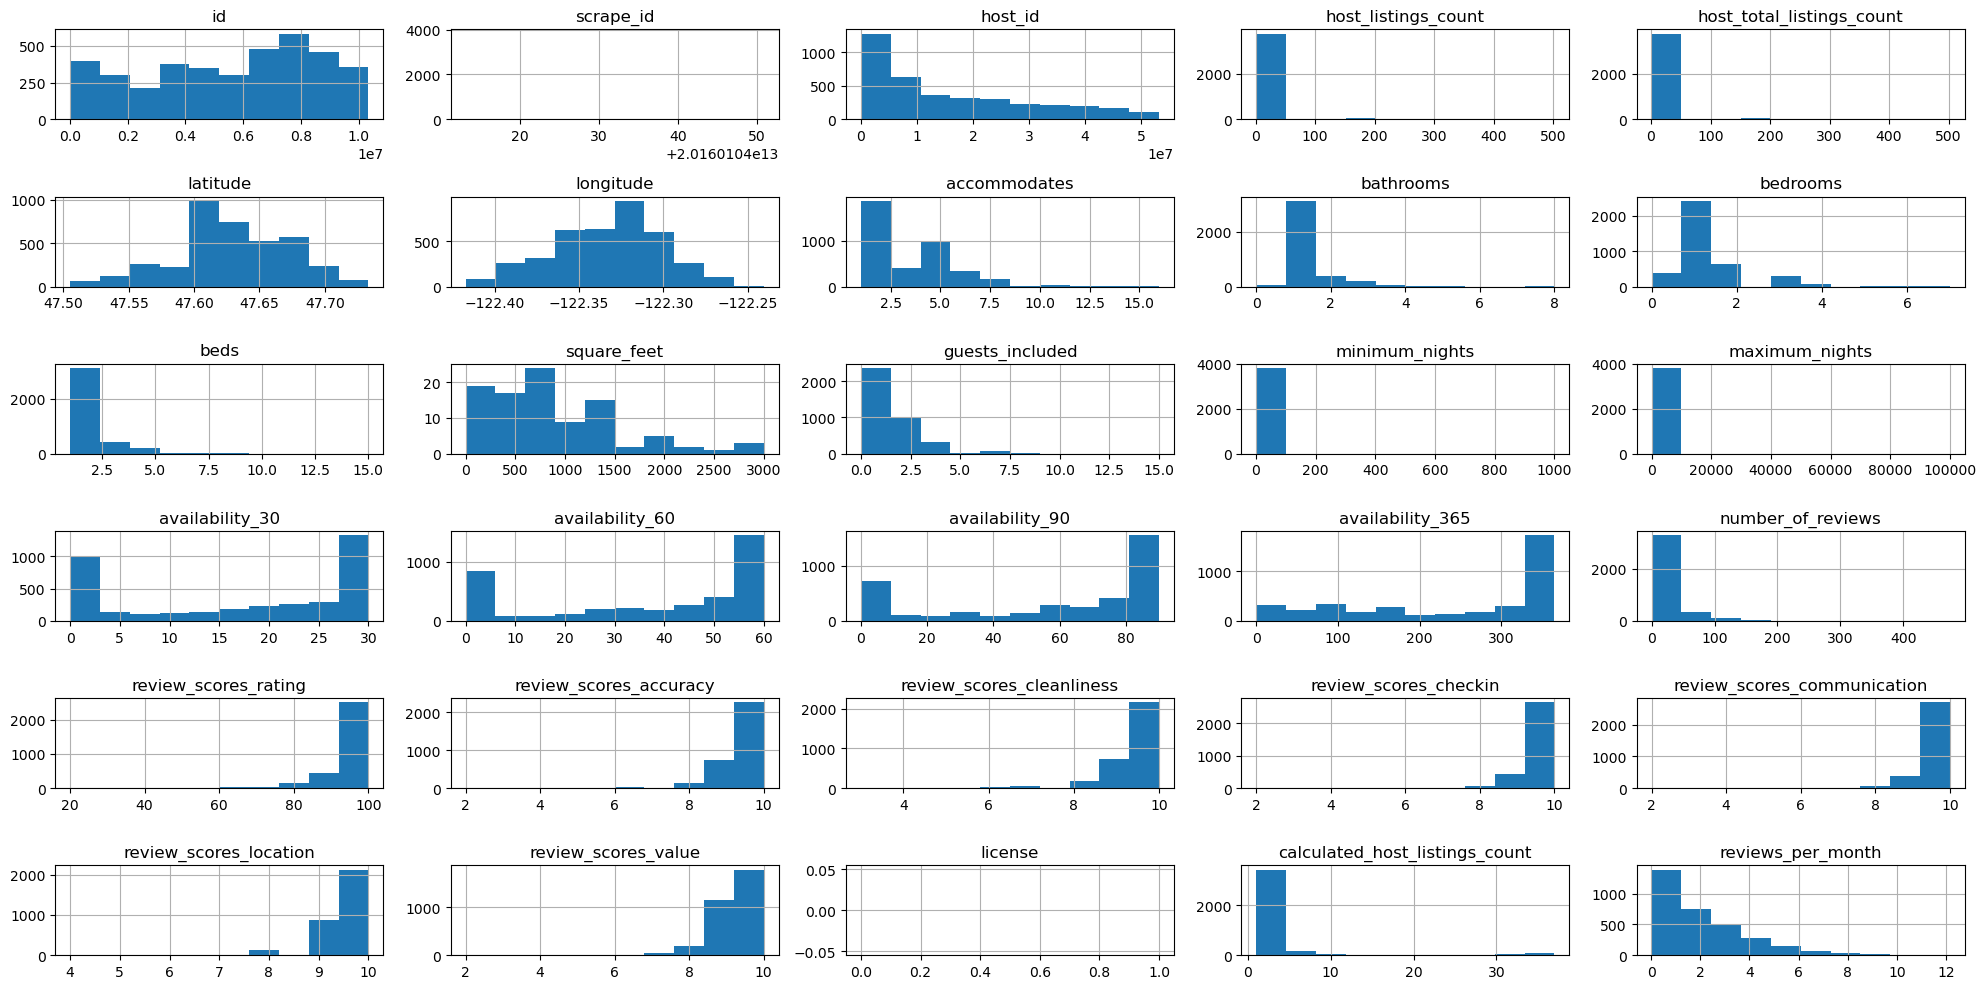





id|| mean: 5,550,111   median: 6,118,244   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

scrape_id|| mean: 20,160,104,002,432   median: 20,160,104,002,432   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

host_id|| mean: 15,785,555   median: 10,558,142   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

host_listings_count|| mean: 7   median: 1   Not_NA: 3,816   NA: 2 proportion_NA: 0.1%

host_total_listings_count|| mean: 7   median: 1   Not_NA: 3,816   NA: 2 proportion_NA: 0.1%

latitude|| mean: 48   median: 48   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

longitude|| mean: -122   median: -122   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

accommodates|| mean: 3   median: 3   Not_NA: 3,818   NA: 0 proportion_NA: 0.0%

bathrooms|| mean: 1   median: 1   Not_NA: 3,802   NA: 16 proportion_NA: 0.4%

bedrooms|| mean: 1   median: 1   Not_NA: 3,812   NA: 6 proportion_NA: 0.2%

beds|| mean: 2   median: 1   Not_NA: 3,817   NA: 1 proportion_NA: 0.0%

square_feet|| mean: 855   median: 750   Not_NA: 97   NA: 3,

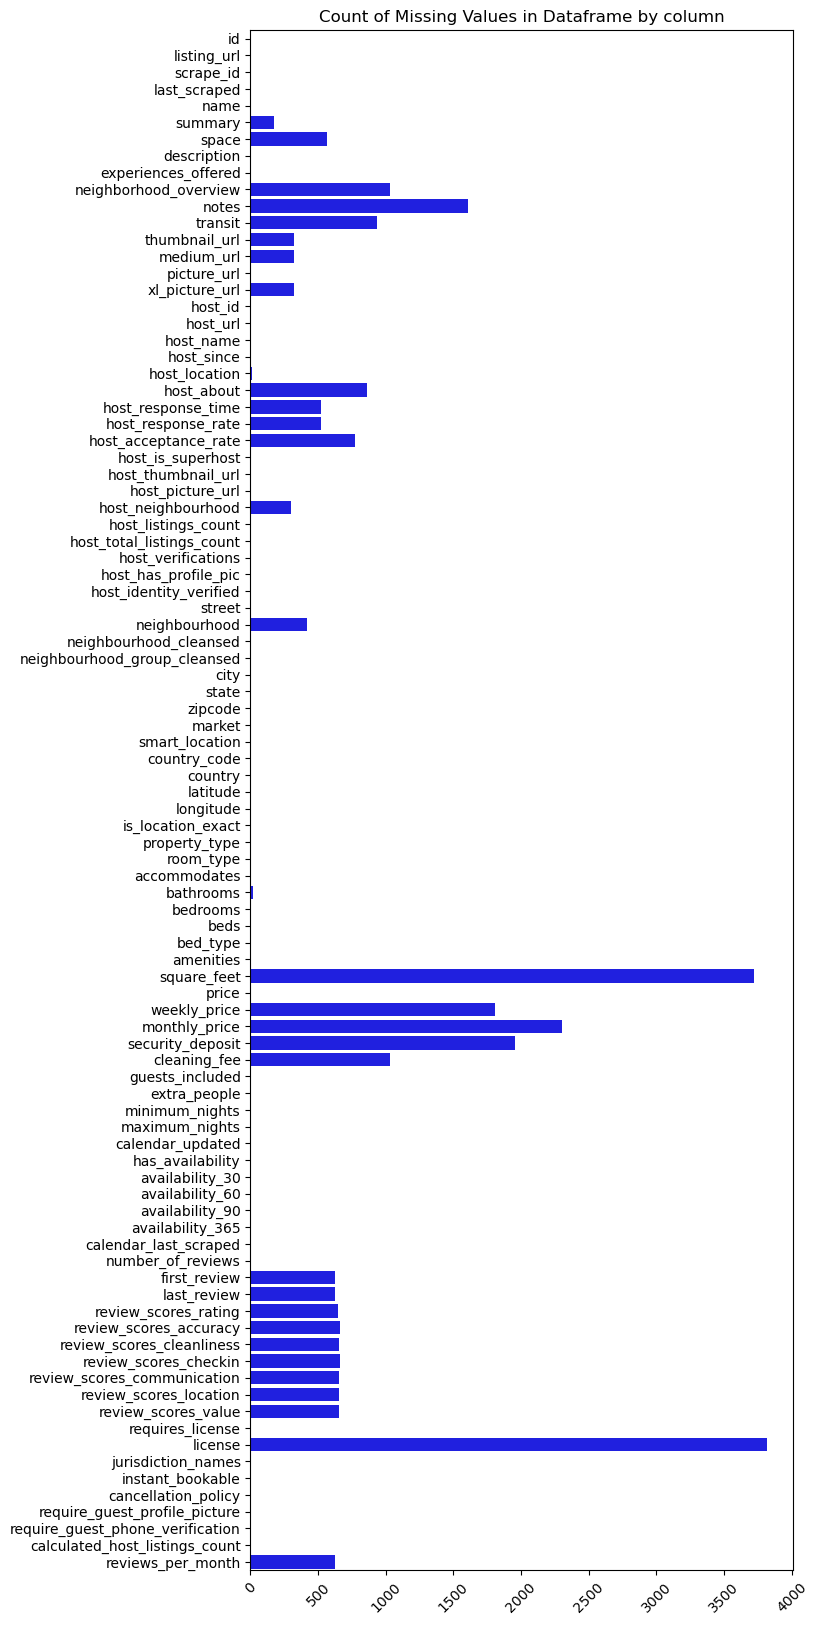

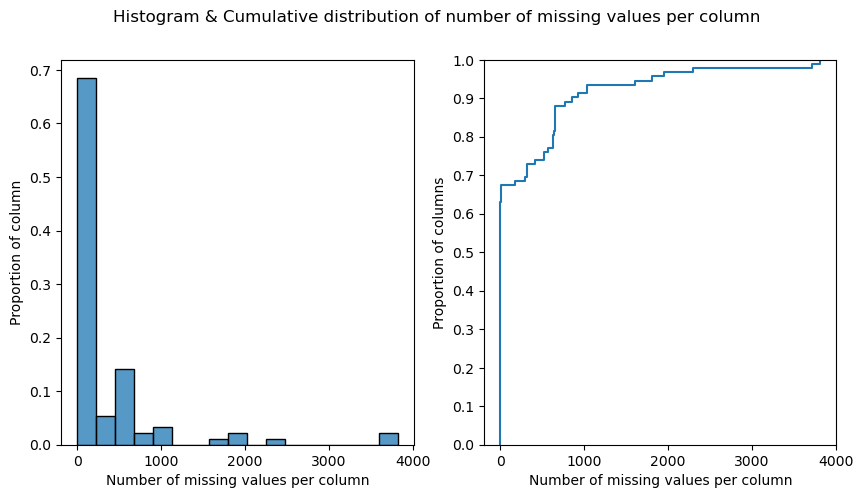

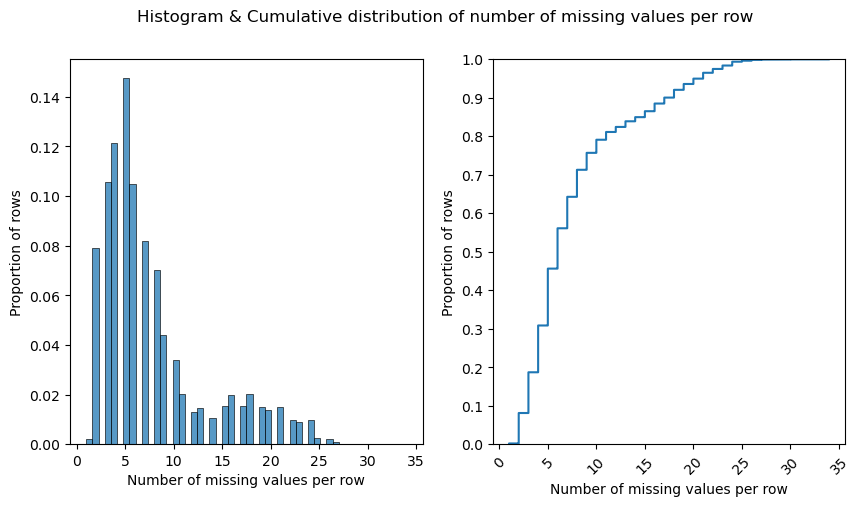

In [289]:
drop_columns, numeric_cols, non_numeric_cols = describe_data(lst,"listings.csv")